In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


### Load and compare celltype proportions

In [2]:
control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')

ko_1 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO1_visiumHD.h5ad')
ko_2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')
ko_3 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO3_visiumHD.h5ad')
ko_4 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')

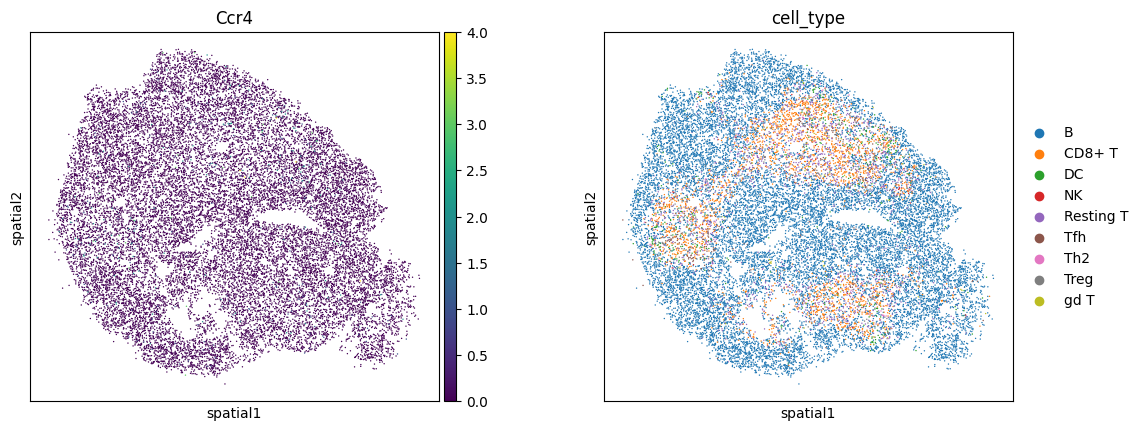

AnnData object with n_obs × n_vars = 20024 × 1852
    obs: 'sample', 'primary_annot', 'secondary_annot', 'tertiary_annot', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_pca', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [3]:
sc.pl.spatial(control, color=['Ccr4', 'cell_type'], spot_size=20)

control

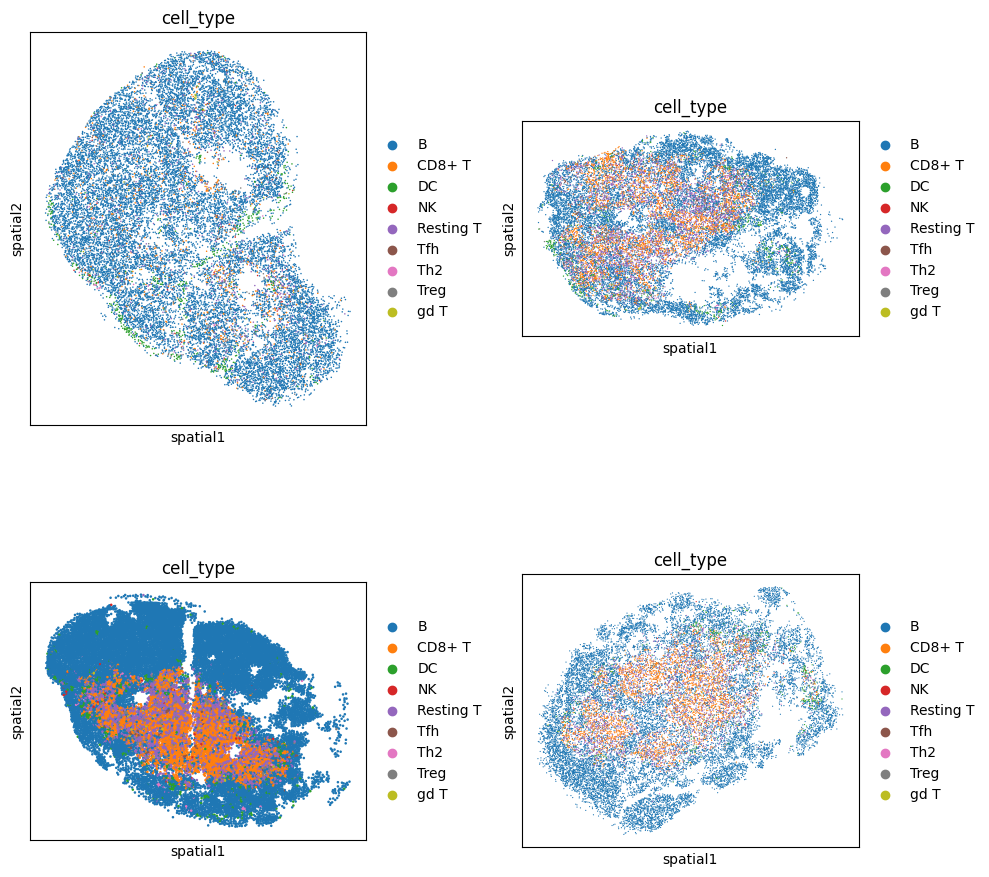

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, adata in enumerate([ko_1, ko_2, ko_3, ko_4]):
    sc.pl.spatial(adata, color='cell_type', spot_size=25, ax=axs[i], show=False)

plt.tight_layout()
plt.show()

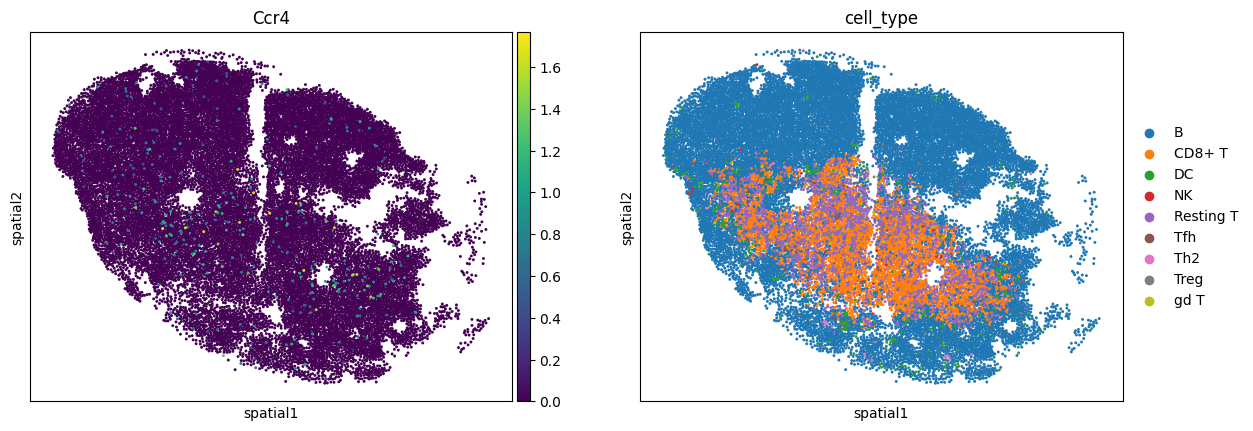

In [5]:
sc.pl.spatial(ko_3, color=['Ccr4', 'cell_type'], spot_size=20)

In [6]:
df = pd.concat(
    [ 
        control.obs['cell_type'].value_counts().rename('control'),
        ko_1.obs['cell_type'].value_counts().rename('ko_1'),
        ko_2.obs['cell_type'].value_counts().rename('ko_2'),
        ko_3.obs['cell_type'].value_counts().rename('ko_3'),
        ko_4.obs['cell_type'].value_counts().rename('ko_4')
    ],axis=1)

df.sum(axis=0)

control    20024
ko_1       20005
ko_2       20058
ko_3       19209
ko_4       20023
dtype: int64

In [7]:
display(df)

,control,ko_1,ko_2,ko_3,ko_4
cell_type,,,,,
B,15165,17454,13088,13284,14043
CD8+ T,2058,764,2795,2714,2684
Resting T,1542,727,2730,2304,2165
DC,398,529,522,390,402
Treg,362,234,321,259,330
Tfh,250,125,343,81,165
Th2,98,73,128,50,72
gd T,82,50,86,81,88
NK,69,49,45,46,74


In [8]:
df_pct = df.div(df.sum(axis=0), axis=1) * 100
display(df_pct)

,control,ko_1,ko_2,ko_3,ko_4
cell_type,,,,,
B,75.734119,87.248188,65.250773,69.155084,70.134346
CD8+ T,10.277667,3.819045,13.934590,14.128794,13.404585
Resting T,7.700759,3.634091,13.610529,11.994378,10.812566
DC,1.987615,2.644339,2.602453,2.030298,2.007691
Treg,1.807831,1.169708,1.600359,1.348326,1.648105
Tfh,1.248502,0.624844,1.710041,0.421677,0.824052
Th2,0.489413,0.364909,0.638149,0.260295,0.359586
gd T,0.409509,0.249938,0.428757,0.421677,0.439495
NK,0.344586,0.244939,0.224349,0.239471,0.369575


In [10]:
df_pct = df.loc[['Resting T', 'Treg', 'Tfh', 'Th2']]
df_pct = df_pct.div(df_pct.sum(axis=0), axis=1) * 100
display(df_pct)

,control,ko_1,ko_2,ko_3,ko_4
cell_type,,,,,
Resting T,68.472469,62.726488,77.512777,85.523385,79.245974
Treg,16.074600,20.189819,9.114140,9.613957,12.079063
Tfh,11.101243,10.785160,9.738785,3.006682,6.039531
Th2,4.351687,6.298533,3.634299,1.855976,2.635432


In [10]:
def count_cells(adata_vis):
    # Count cells with different marker combinations
    ccr4_cells = adata_vis.obs_names[adata_vis[:, 'Ccr4'].X.toarray().flatten() > 0]
    prdm1_cells = adata_vis.obs_names[adata_vis[:, 'Prdm1'].X.toarray().flatten() > 0]
    ccr4_prdm1_cells = set(ccr4_cells) & set(prdm1_cells)
    ccr4_neg_cells = set(adata_vis.obs_names) - set(ccr4_cells)
    prdm1_only_cells = set(prdm1_cells) - set(ccr4_cells)

    # Create dataframe with cell counts
    cell_counts = pd.DataFrame({
        'Cell Type': ['Ccr4+', 'Ccr4-', 'Prdm1+', 'Ccr4+ Prdm1+', 'Ccr4- Prdm1+'],
        'Count': [len(ccr4_cells), len(ccr4_neg_cells), len(prdm1_cells), len(ccr4_prdm1_cells), len(prdm1_only_cells)]
    })

    return cell_counts 

In [11]:
counts = pd.concat([
    count_cells(control)[['Cell Type', 'Count']], 
    count_cells(ko_1)['Count'], 
    count_cells(ko_2)['Count'], 
    count_cells(ko_3)['Count'], 
    count_cells(ko_4)['Count']
], axis=1)

counts.columns = ['cell_type', 'control', 'ko_1', 'ko_2', 'ko_3', 'ko_4']
counts

,cell_type,control,ko_1,ko_2,ko_3,ko_4
0,Ccr4+,357,185,765,291,330
1,Ccr4-,19667,19820,19293,18918,19693
2,Prdm1+,237,108,401,305,277
3,Ccr4+ Prdm1+,29,7,81,7,32
4,Ccr4- Prdm1+,208,101,320,298,245


In [12]:
counts.set_index('cell_type', inplace=True)

counts_pct = counts.loc[['Ccr4+ Prdm1+', 'Ccr4- Prdm1+']]
counts_pct = counts_pct / counts_pct.sum(axis=0) * 100
counts_pct

,control,ko_1,ko_2,ko_3,ko_4
cell_type,,,,,
Ccr4+ Prdm1+,12.236287,6.481481,20.199501,2.295082,11.552347
Ccr4- Prdm1+,87.763713,93.518519,79.800499,97.704918,88.447653


### Look at cell type proportion in 1DER environment

In [ ]:
control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
